In [31]:
# ====== 基础库 ======
import os
import re
import glob
import numpy as np
from scipy.io import loadmat, savemat
from scipy.ndimage import map_coordinates
from scipy.optimize import minimize
import subprocess
import nibabel as nib                          # 处理 NIfTI 文件
from fsl.wrappers import flirt, fslmaths, bet      # FSL 工具包，配准与图像运算
from nipype.interfaces.dcm2nii import Dcm2niix
# ====== 可视化 ======
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
from IPython.display import display

# ====== 高维数据操作（如 patch 操作） ======
from einops import rearrange


In [32]:
def process_dicom_to_deltaB0(dicom_directory, nifti_folder, delta_TE, Frequency):
    """
    Converts DICOM files to NIfTI format, performs phase unwrapping, applies a brain mask, and calculates delta B0 maps.

    Parameters:
        dicom_directory (str): Path to the directory containing DICOM files.
        nifti_folder (str): Path to the directory where NIfTI files will be saved.
        delta_TE (float): Echo time difference in seconds.
        Frequency (float): Scanner frequency in MHz (e.g., 127.74 MHz for a 3T scanner).
    """
    print("启动！")
    directories = os.listdir(dicom_directory)

    for directory in directories:
        try:
            dicom_file_path = os.path.join(dicom_directory, directory)
            nifti_file_path = os.path.join(nifti_folder, f"{directory}_nii")
            os.makedirs(nifti_file_path, exist_ok=True)

            # Convert DICOM to NIfTI format
            converter = Dcm2niix()
            converter.inputs.source_dir = dicom_file_path
            converter.inputs.output_dir = nifti_file_path
            converter.run()
            # Identify phase and magnitude images
            phase_map = glob.glob(os.path.join(nifti_file_path, "*ph.nii.gz*"))
            magnitude_map = glob.glob(os.path.join(nifti_file_path, "*e2.nii.gz*"))

            if phase_map and magnitude_map:
                # Load the phase image and normalize it to range [-π, π]
                phase_map_nifti = nib.load(phase_map[0])
                phase_map_data = phase_map_nifti.get_fdata()
                affine = phase_map_nifti.affine.copy()
                header = phase_map_nifti.header.copy()

                phasemap = phase_map_data / 4096 * np.pi
                phase_map_img_valid = nib.Nifti1Image(phasemap, affine, header)
                phase_map_img_valid_path = os.path.join(nifti_file_path, f"{directory}_PhaseMap.nii.gz")
                nib.save(phase_map_img_valid, phase_map_img_valid_path)

                # Generate brain mask using BET (Brain Extraction Tool)
                bet_path = os.path.join(nifti_file_path, f"{directory}_bet.nii.gz")
                bet(magnitude_map[0], bet_path, f=0.1, m=True)

                # Apply the brain mask to the phase image
                mask_path = os.path.join(nifti_file_path, f"{directory}_bet_mask.nii.gz")
                brain_map_path = os.path.join(nifti_file_path, f"{directory}_BrainMap.nii.gz")
                fslmaths(phase_map_img_valid_path).mul(mask_path).run(brain_map_path)

                # Perform phase unwrapping
                unwrap_path = os.path.join(nifti_file_path, f"{directory}_unwrapped_Brain.nii.gz")
                cmd = [
                    "prelude",
                    "-p", brain_map_path,
                    "-a", magnitude_map[0],
                    "-o", unwrap_path
                ]
                subprocess.run(cmd, check=True)

                # Calculate delta B0 in Hz
                deltB0_hertz_path = os.path.join(nifti_file_path, f"{directory}_deltaB0_hertz.nii.gz")
                fslmaths(unwrap_path).div(2).div(np.pi).div(delta_TE).run(deltB0_hertz_path)

                # Calculate delta B0 in ppm
                deltB0_ppm_path = os.path.join(nifti_file_path, f"{directory}_deltaB0_ppm.nii.gz")
                fslmaths(deltB0_hertz_path).div(Frequency).run(deltB0_ppm_path)

                print(f"Processing completed for {directory}")
            else:
                print(f"Phase or magnitude images not found for {directory}")
        
        except Exception as e:
            print(f"Error processing {directory}: {e}")

In [205]:
dicom = r"./Dicom"
nii = r"./Nifti"
delta_TE = 0.00246  # Echo time difference in seconds
Frequency = 42.58 * 5  # Scanner frequency in MHz for 5T
process_dicom_to_deltaB0(dicom, nii, delta_TE, Frequency)

启动！
250709-22:26:59,457 nipype.interface INFO:
	 stdout 2025-07-09T22:26:59.457879:Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
250709-22:26:59,458 nipype.interface INFO:
	 stdout 2025-07-09T22:26:59.457879:Found 348 DICOM file(s)
250709-22:26:59,458 nipype.interface INFO:
	 stdout 2025-07-09T22:26:59.457879:Convert 116 DICOM as Nifti/PLS_pfc_noshim_nii/PLS_pfc_noshim_pls_pfc_noshim_real2_20250709193921_1101 (132x100x116x1)
250709-22:26:59,531 nipype.interface INFO:
	 stdout 2025-07-09T22:26:59.531733:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "Nifti/PLS_pfc_noshim_nii/PLS_pfc_noshim_pls_pfc_noshim_real2_20250709193921_1101.nii"
250709-22:26:59,532 nipype.interface INFO:
	 stdout 2025-07-09T22:26:59.531733:Convert 116 DICOM as Nifti/PLS_pfc_noshim_nii/PLS_pfc_noshim_pls_pfc_noshim_real2_20250709193921_1103_ph (132x100x116x1)
250709-22:26:59,566 nipype.interface INFO:
	 stdout 2025-07-09T22:26:59.566902:Compress: "/usr/bin/pigz" -b 960 -n 

In [305]:
# ========== 配置路径 ==========
mag = "Nifti/CY_PFC_test3_nii/CY_PFC_test3_pfc-shim1_lzy2_20250709141354_1102_e2.nii.gz"
brain_mask = "Nifti/CY_PFC_test3_nii/CY_PFC_test3_bet_mask.nii.gz"
mag_brain = "Nifti/CY_PFC_nii/CY_PFC_brain_mag.nii.gz"

mni_t1 = "MNI152_T1_1mm_brain.nii.gz"
mask_mni = "pfc_mask.nii.gz"

mni_in_native = "Nifti/PLS_ref_noshim_nii/registered_MNI152.nii.gz"
xfm_matrix = "Nifti/PLS_ref_noshim_nii/pfc2native.mat"
mask_in_native = "Nifti/CY_PFC_nii/cy_pfc_mask.nii.gz"

# ========== Step 1: BET 去颅骨处理 ==========
print(">> BET 去颅骨中...")
fslmaths(mag).mul(brain_mask).run(mag_brain)

# ========== Step 2: MNI -> native 配准 ==========
print(">> MNI → MAG 配准中...")
flirt(
    mni_t1,
    mag_brain,
    out=mni_in_native,
    omat=xfm_matrix,
    dof=12,
    cost='mutualinfo'
)

# ========== Step 3: 将 MNI mask 应用到个体空间 ==========
print(">> PFC mask 映射到 native 空间中...")
flirt(
    mask_mni,
    mag_brain,
    out=mask_in_native,
    init=xfm_matrix,
    applyxfm=True,
    interp="nearestneighbour"
)

>> BET 去颅骨中...
>> MNI → MAG 配准中...
>> PFC mask 映射到 native 空间中...


{}

In [230]:
def resample_to_reference(source_img, reference_img):
    """
    将 source_img 的数据重采样到 reference_img 的空间。
    返回新的 Nifti1Image。
    """
    source_data = source_img.get_fdata()
    source_affine = source_img.affine
    reference_affine = reference_img.affine
    reference_shape = reference_img.shape

    # 构建参考图像中的体素坐标网格
    ref_coords = np.indices(reference_shape)
    ref_coords = np.reshape(ref_coords, (3, -1))  # (3, N)

    # 将参考图像体素坐标映射到世界坐标
    ref_world = nib.affines.apply_affine(reference_affine, ref_coords.T)

    # 将世界坐标映射回原图像的体素坐标（反向）
    src_coords = np.linalg.inv(source_affine).dot(np.vstack((ref_world.T, np.ones((1, ref_world.shape[0])))))[:3, :]

    # 三线性插值
    resampled_data = map_coordinates(source_data, src_coords, order=1, mode='nearest').reshape(reference_shape)

    return nib.Nifti1Image(resampled_data, reference_affine)

def batch_resample_with_nibabel(root_folder, reference_file):
    """
    用 nibabel+scipy 方式重采样 n 通道的 deltaFieldmap 数据。
    """
    if not os.path.exists(reference_file):
        raise FileNotFoundError("❌ Reference file not found.")

    reference_img = nib.load(reference_file)
    resampled_paths = []

    for ch in range(1, 11):
        ch_folder = os.path.join(root_folder, f"ch{ch}_nii")
        if not os.path.isdir(ch_folder):
            print(f"⚠️ Skipping {ch_folder} (not a directory)")
            continue

        delta_files = glob.glob(os.path.join(ch_folder, f"ch{ch}_nii_deltaFieldmap.nii*"))
        if not delta_files:
            print(f"❌ deltaFieldmap not found in {ch_folder}")
            continue
        delta_path = delta_files[0]

        try:
            source_img = nib.load(delta_path)
            resampled_img = resample_to_reference(source_img, reference_img)

            resampled_path = os.path.join(ch_folder, f"ch{ch}_nii_resampled_to_brain.nii.gz")
            nib.save(resampled_img, resampled_path)
            resampled_paths.append(resampled_path)

            print(f"✅ ch{ch} resampled and saved to {resampled_path}")
        except Exception as e:
            print(f"❌ Resampling failed for ch{ch}: {e}")

    return resampled_paths


In [231]:
resampled_files = batch_resample_with_nibabel(
    root_folder="SF_coil_profile_nii",
    reference_file="Nifti/PLS_ref_noshim_nii/PLS_ref_noshim_pls_ref_noshim_20250709193921_402_e2.nii.gz")

print("\n✅ All resampled files:")
for path in resampled_files:
    img = nib.load(path)
    data = img.get_fdata()
    print(f"{os.path.basename(path)}: shape={data.shape}, mean={data.mean():.4f}, std={data.std():.4f}")


✅ ch1 resampled and saved to SF_coil_profile_nii/ch1_nii/ch1_nii_resampled_to_brain.nii.gz
✅ ch2 resampled and saved to SF_coil_profile_nii/ch2_nii/ch2_nii_resampled_to_brain.nii.gz
✅ ch3 resampled and saved to SF_coil_profile_nii/ch3_nii/ch3_nii_resampled_to_brain.nii.gz
✅ ch4 resampled and saved to SF_coil_profile_nii/ch4_nii/ch4_nii_resampled_to_brain.nii.gz
✅ ch5 resampled and saved to SF_coil_profile_nii/ch5_nii/ch5_nii_resampled_to_brain.nii.gz
✅ ch6 resampled and saved to SF_coil_profile_nii/ch6_nii/ch6_nii_resampled_to_brain.nii.gz
✅ ch7 resampled and saved to SF_coil_profile_nii/ch7_nii/ch7_nii_resampled_to_brain.nii.gz
✅ ch8 resampled and saved to SF_coil_profile_nii/ch8_nii/ch8_nii_resampled_to_brain.nii.gz
✅ ch9 resampled and saved to SF_coil_profile_nii/ch9_nii/ch9_nii_resampled_to_brain.nii.gz
✅ ch10 resampled and saved to SF_coil_profile_nii/ch10_nii/ch10_nii_resampled_to_brain.nii.gz

✅ All resampled files:
ch1_nii_resampled_to_brain.nii.gz: shape=(132, 100, 116), mean=

In [287]:
# ========= 路径配置 =========
target_path = r"Nifti/PLS_ref_noshim_nii/PLS_ref_noshim_deltaB0_hertz.nii.gz"
mask_path   = r"Nifti/PLS_ref_noshim_nii/pls_pfc_mask.nii.gz"
channel_folder = r"SF_coil_profile_nii"

# ========= 工具函数 =========
def natural_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

# ========= 加载全脑目标场 & ROI mask =========
B0_target = nib.load(target_path).get_fdata()   # Hz → ppm
target_affine = nib.load(target_path).affine
target_shape = B0_target.shape

mask = nib.load(mask_path).get_fdata()
mask = (mask > 0.5).astype(np.float32)

# ========= 加载所有通道响应 =========
sorted_channels = sorted(os.listdir(channel_folder), key=natural_key)
B0_list = []
for ch_name in sorted_channels:
    ch_path = os.path.join(channel_folder, ch_name, f"{ch_name}_resampled_to_brain.nii.gz")
    if os.path.exists(ch_path):
        B0_ch = nib.load(ch_path).get_fdata()
        B0_list.append(B0_ch)
    else:
        print(f"[警告] 通道 {ch_name} 缺失文件：{ch_path}")

B0_array = np.stack(B0_list, axis=-1)  # shape: (X, Y, Z, n_channels)

# ========= 构造优化所用 A 矩阵 & b 向量（仅在 mask 区）=========
b_flat = B0_target.flatten()
mask_flat = mask.flatten()
valid_idx = (mask_flat > 0.5)

b = b_flat[valid_idx]  # shape: (N_roi,)
A = B0_array.reshape(-1, B0_array.shape[-1])[valid_idx]  # shape: (N_roi, n_channels)
# ========= 提取非 ROI 区域 =========
nonroi_idx = (mask_flat <= 0.5)
A_nonroi = B0_array.reshape(-1, B0_array.shape[-1])[nonroi_idx]

# ========= 优化配置 =========
n_channels = A.shape[1]
initial_weights = np.ones(n_channels) / n_channels
bounds = [(-3.0, 3.0)] * n_channels  # 每通道电流范围 ±4A

# ========= 损失函数 =========
lambda_penalty = 0.1 # 非ROI区域惩罚权重

def loss_mse(w):
    roi_term = np.mean((A @ w + b) ** 2)
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return roi_term + lambda_penalty * nonroi_term

def loss_max(w):
    roi_term = np.max(np.abs(A @ w + b))
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return roi_term + lambda_penalty * nonroi_term

def loss_ptp(w):
    r = A @ w - b
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return (r.max() - r.min()) + lambda_penalty * nonroi_term

loss_dict = {
    "MSE (L2)": loss_mse,
    "Max Error": loss_max,
    "Peak-to-Peak": loss_ptp,
}

# ========= 多目标优化 & 全脑评估 =========
results = {}
for name, loss_func in loss_dict.items(): 
    print(f"\n>>> 正在优化目标函数: {name}")
    res = minimize(loss_func, initial_weights, bounds=bounds, method='L-BFGS-B')
    shim_currents = res.x
    # 全脑残差评估
    B0_compensated = np.tensordot(B0_array, shim_currents, axes=([3], [0]))
    residual_map = B0_target + B0_compensated

    results[name] = {
        'currents': shim_currents,
        'residual': residual_map,
        'loss': loss_func(shim_currents)
    }

# ========= 打印并保存电流结果 =========
with open("shim_currents_pfc.txt", "w") as f:
    for name, data in results.items():
        print(f"\n====== {name} ======")
        print(f"Loss (ROI): {data['loss']:.3f}")
        f.write(f"### {name} ###\nLoss: {data['loss']:.3f}\n")
        for i, val in enumerate(data['currents']):
            line = f"ch{i+1:02d}: {val:.3f} A"
            print(line)
            f.write(line + "\n")
        f.write("\n")



>>> 正在优化目标函数: MSE (L2)

>>> 正在优化目标函数: Max Error

>>> 正在优化目标函数: Peak-to-Peak

====== MSE (L2) ======
Loss (ROI): 2864.616
ch01: 2.085 A
ch02: -1.037 A
ch03: -0.385 A
ch04: 0.137 A
ch05: -3.000 A
ch06: 0.482 A
ch07: -0.353 A
ch08: -0.986 A
ch09: 0.613 A
ch10: 0.566 A

====== Max Error ======
Loss (ROI): 499.046
ch01: 0.218 A
ch02: -0.597 A
ch03: 0.151 A
ch04: -0.027 A
ch05: -0.176 A
ch06: -0.008 A
ch07: -0.005 A
ch08: -0.072 A
ch09: 0.015 A
ch10: -0.038 A

====== Peak-to-Peak ======
Loss (ROI): 544.050
ch01: 0.031 A
ch02: 0.011 A
ch03: -0.004 A
ch04: 0.006 A
ch05: -0.007 A
ch06: -0.010 A
ch07: 0.007 A
ch08: -0.020 A
ch09: 0.016 A
ch10: 0.012 A


/tmp/ipykernel_1928474/2311921001.py:22: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928474/2311921001.py:22: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928474/2311921001.py:22: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1928474/2311921001.py:22: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mgzszmzjz/.conda/envs/lpc/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mgzszmzjz/.conda/envs/lpc/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27969 (\N{CJK UNIFIED IDEOGRAPH-6D41}) missin

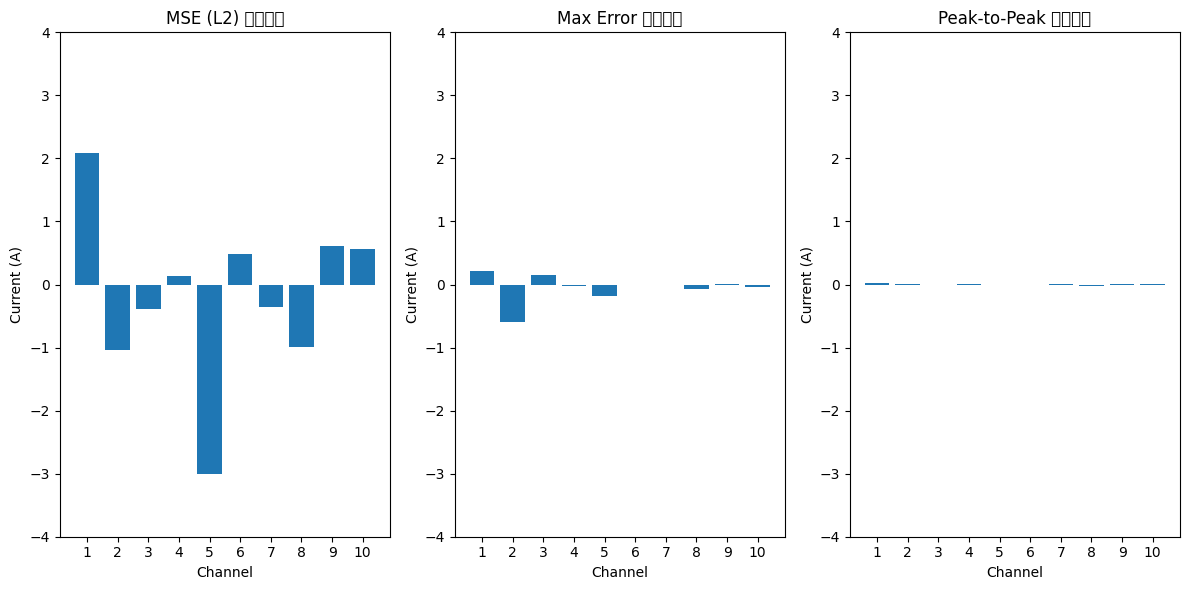

In [288]:
def plot_currents_histograms(results):
    """
    results: dict, key是目标函数名字，value是包含 'currents' numpy数组的字典
    """
    plt.figure(figsize=(12, 6))

    target_names = list(results.keys())
    n_targets = len(target_names)
    n_channels = len(next(iter(results.values()))['currents'])

    # 每个目标函数画一个子图
    for i, name in enumerate(target_names):
        currents = results[name]['currents']
        plt.subplot(1, n_targets, i+1)
        plt.bar(np.arange(1, n_channels+1), currents, color='tab:blue')
        plt.ylim(-4, 4)  # 你电流范围±3，这里稍微放开一点
        plt.xlabel("Channel")
        plt.ylabel("Current (A)")
        plt.title(f"{name} 电流分布")
        plt.xticks(np.arange(1, n_channels+1))

    plt.tight_layout()
    plt.show()

plot_currents_histograms(results)


In [ ]:
views = {
    'Axial (Z)': lambda vol, idx: vol[:, :, idx],
    'Coronal (Y)': lambda vol, idx: vol[:, idx, :],
    'Sagittal (X)': lambda vol, idx: vol[idx, :, :]
}


max_indices = {
    'Axial (Z)': target_shape[2] - 1,
    'Coronal (Y)': target_shape[1] - 1,
    'Sagittal (X)': target_shape[0] - 1
}

sliders = {
    direction: widgets.IntSlider(value=dim // 2, min=0, max=dim - 1, description=direction.split()[0], continuous_update=False)
    for direction, dim in max_indices.items()
}

def plot_interactive(axial_idx, coronal_idx, sagittal_idx):
    slice_indices = {
        'Axial (Z)': axial_idx,
        'Coronal (Y)': coronal_idx,
        'Sagittal (X)': sagittal_idx
    }

    n_views = len(views)
    n_rows = len(results) + 1 
    plt.figure(figsize=(4 * n_views, 3 * n_rows))

    for j, (view_name, slicer) in enumerate(views.items()):
        idx = slice_indices[view_name]
        plt.subplot(n_rows, n_views, j + 1)
        plt.imshow(slicer(B0_target, idx).T, cmap='jet', vmin=-450, vmax=450, origin='lower')
        plt.title(f"Ref - {view_name}")
        plt.colorbar()

    for i, (name, data) in enumerate(results.items()):
        res_3d = data['residual'] 
        for j, (view_name, slicer) in enumerate(views.items()):
            idx = slice_indices[view_name]
            plt.subplot(n_rows, n_views, (i + 1) * n_views + j + 1)
            plt.imshow(slicer(res_3d, idx).T, cmap='jet', vmin=-450, vmax=450, origin='lower')
            plt.title(f"{name} - {view_name}")
            plt.colorbar()

    plt.tight_layout()
    plt.show() 

ui = widgets.VBox([widgets.HBox(list(sliders.values()))])
out = widgets.interactive_output(plot_interactive, {
    'axial_idx': sliders['Axial (Z)'],
    'coronal_idx': sliders['Coronal (Y)'],
    'sagittal_idx': sliders['Sagittal (X)']
})

display(ui, out)


Output()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
mask_whole_brain = nib.load("Nifti/PLS_ref_noshim_nii/pls_pfc_mask.nii.gz").get_fdata()
def masked_slice(data, mask, slicer, idx):
    slice_data = slicer(data, idx)
    slice_mask = slicer(mask, idx)
    slice_data_masked = np.where(slice_mask > 0.5, slice_data, np.nan)
    return slice_data_masked

views = {
    'Axial (Z)': lambda vol, idx: vol[:, :, idx],
    'Coronal (Y)': lambda vol, idx: vol[:, idx, :],
    'Sagittal (X)': lambda vol, idx: vol[idx, :, :]
}

max_indices = {
    'Axial (Z)': target_shape[2] - 1,
    'Coronal (Y)': target_shape[1] - 1,
    'Sagittal (X)': target_shape[0] - 1
}

sliders = {
    direction: widgets.IntSlider(value=dim // 2, min=0, max=dim - 1, description=direction.split()[0], continuous_update=False)
    for direction, dim in max_indices.items()
}

def plot_interactive(axial_idx, coronal_idx, sagittal_idx):
    slice_indices = {
        'Axial (Z)': axial_idx,
        'Coronal (Y)': coronal_idx,
        'Sagittal (X)': sagittal_idx
    }
    n_views = len(views)
    n_rows = len(results) + 1 

    fig, axs = plt.subplots(n_rows, n_views, figsize=(4 * n_views, 3 * n_rows), squeeze=False)
    vmin, vmax = -400, 400  

    for j, (view_name, slicer) in enumerate(views.items()):
        ax = axs[0, j]
        img = masked_slice(B0_target, mask_whole_brain, slicer, slice_indices[view_name]).T
        im = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax, origin='lower')
        ax.set_title(f"Ref - {view_name}")
        ax.axis('off')

    for i, (name, data) in enumerate(results.items()):
        res_3d = data['residual']
        for j, (view_name, slicer) in enumerate(views.items()):
            ax = axs[i + 1, j]
            img = masked_slice(res_3d, mask_whole_brain, slicer, slice_indices[view_name]).T
            im = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax, origin='lower')
            ax.set_title(f"{name} - {view_name}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

ui = widgets.VBox([widgets.HBox(list(sliders.values()))])
out = widgets.interactive_output(plot_interactive, {
    'axial_idx': sliders['Axial (Z)'],
    'coronal_idx': sliders['Coronal (Y)'],
    'sagittal_idx': sliders['Sagittal (X)']
})

display(ui, out)


Output()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def interactive_B0_viewer(B0_maps, vmin=-75, vmax=75):
    views = {
        "Sagittal": lambda vol, idx: vol[idx, :, :],
        "Coronal": lambda vol, idx: vol[:, idx, :],
        "Axial": lambda vol, idx: vol[:, :, idx]
    }

    shape = B0_maps['no_shim'].shape
    methods = list(B0_maps.keys())

    sag_slider = widgets.IntSlider(min=0, max=shape[0]-1, value=shape[0]//2, description='Sagittal')
    cor_slider = widgets.IntSlider(min=0, max=shape[1]-1, value=shape[1]//2, description='Coronal')
    axi_slider = widgets.IntSlider(min=0, max=shape[2]-1, value=shape[2]//2, description='Axial')

    sliders = widgets.HBox([sag_slider, cor_slider, axi_slider])

    output = widgets.Output()

    def plot_slices(sag, cor, axi):
        with output:
            output.clear_output(wait=True)
            slice_dict = {"Sagittal": sag, "Coronal": cor, "Axial": axi}
            fig, axes = plt.subplots(len(methods), len(views), figsize=(12, 3 * len(methods)))

            for i, method in enumerate(methods):
                B0 = B0_maps[method]
                for j, (view_name, slicer) in enumerate(views.items()):
                    idx = slice_dict[view_name]
                    img = slicer(B0, idx).T
                    ax = axes[i, j]
                    ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax, origin='lower')
                    ax.set_title(f"{method} - {view_name}")
                    ax.axis("off")
                    fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.01)

            plt.tight_layout()
            plt.show()

    ui = widgets.interactive_output(plot_slices, {
        'sag': sag_slider,
        'cor': cor_slider,
        'axi': axi_slider
    })

    app = widgets.VBox([sliders, output])
    display(app)

    plot_slices(sag_slider.value, cor_slider.value, axi_slider.value)


In [303]:
mask = nib.load("Nifti/PLS_ref_noshim_nii/pls_pfc_mask.nii.gz").get_fdata()
def residual_stats(residual, mask=None):
    if mask is not None:
        vals = residual[mask > 0.5]
    else:
        vals = residual.flatten()
    rmse = np.sqrt(np.mean(vals ** 2))
    max_abs = np.max(np.abs(vals))
    std = np.std(vals)
    return rmse, max_abs, std

def improvement_percent(ref, new):
    if ref == 0:
        return 0.0
    return 100.0 * (ref - new) / abs(ref)

# 计算参考残差统计（无补偿时，即原始场本身）
residual_ref = B0_target.copy()
rmse_ref, max_abs_ref, std_ref = residual_stats(residual_ref, mask)
print("\n====== 原始参考场残差统计（无补偿） ======")
print(f"RMSE: {rmse_ref:.4f} Hz")
print(f"Max Abs Residual: {max_abs_ref:.4f} Hz")
print(f"Std: {std_ref:.4f} Hz")

# 优化结果残差统计和对比（用百分比表示提升）
for name, data in results.items():
    rmse, max_abs, std = residual_stats(data['residual'], mask)
    rmse_impr = improvement_percent(rmse_ref, rmse)
    max_abs_impr = improvement_percent(max_abs_ref, max_abs)
    std_impr = improvement_percent(std_ref, std)

    print(f"\n====== {name} 优化后残差统计（ROI区域） ======")
    print(f"RMSE: {rmse:.4f} Hz (提升: {rmse_impr:.2f}%)")
    print(f"Max Abs Residual: {max_abs:.4f} Hz (提升: {max_abs_impr:.2f}%)")
    print(f"Std: {std:.4f} Hz (提升: {std_impr:.2f}%)")



====== 原始参考场残差统计（无补偿） ======
RMSE: 80.1934 Hz
Max Abs Residual: 509.5179 Hz
Std: 62.7275 Hz

====== MSE (L2) 优化后残差统计（ROI区域） ======
RMSE: 48.4736 Hz (提升: 39.55%)
Max Abs Residual: 424.1762 Hz (提升: 16.75%)
Std: 47.9668 Hz (提升: 23.53%)

====== Max Error 优化后残差统计（ROI区域） ======
RMSE: 69.2562 Hz (提升: 13.64%)
Max Abs Residual: 488.5717 Hz (提升: 4.11%)
Std: 61.6887 Hz (提升: 1.66%)

====== Peak-to-Peak 优化后残差统计（ROI区域） ======
RMSE: 80.3355 Hz (提升: -0.18%)
Max Abs Residual: 509.5133 Hz (提升: 0.00%)
Std: 62.5487 Hz (提升: 0.28%)


In [ ]:
from fsl.wrappers import flirt

ref_img = "Dicom/EPI_PFC_Dicom/EPI_ref_noshim/epi_noshim.nii.gz"      # 参考图像
in_img  = "Dicom/EPI_PFC_Dicom/EPI_pfc_shimming/epi_pfc_shimming.nii.gz"      # 待配准图像
out_img = "Dicom/EPI_PFC_Dicom/EPI_pfc_shimming/epi_pfc_shimming_registered.nii.gz"
mat_txt = "Dicom/EPI_PFC_Dicom/EPI_pfc_shimming/EPI.mat" # 输出变换矩阵

flirt(src=in_img, ref=ref_img, out = out_img, omat=mat_txt, dof=6, cost='mutualinfo')


{}

In [271]:
def visualize_all_channels(root_folder, pattern="deltaFieldmap", slice_index=None, view='axial',
                           vmax=150, vmin=-150, save_path="deltaFieldmap_channels.png"):
    """
    可视化每个通道的 deltaFieldmap 场图切片（某个方向），去除绿色背景，并保存为 PNG。
    """
    import matplotlib.pyplot as plt
    import nibabel as nib
    import numpy as np
    import os
    import glob

    view_map = {
        'axial': lambda x: x[:, :, slice_index],
        'coronal': lambda x: x[:, slice_index, :],
        'sagittal': lambda x: x[slice_index, :, :]
    }

    assert view in view_map, f"Invalid view: {view}. Choose from 'axial', 'coronal', or 'sagittal'."

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    cmap = plt.cm.seismic  # 蓝-白-红
    cmap.set_bad(color='white')  # NaN 显示为黑色背景

    for ch in range(1, 11):
        ch_folder = os.path.join(root_folder, f"ch{ch}_nii")
        delta_files = glob.glob(os.path.join(ch_folder, f"ch{ch}_nii_*{pattern}*.nii*"))
        if not delta_files:
            print(f"❌ 找不到通道 ch{ch} 的场图文件")
            continue

        img = nib.load(delta_files[0]).get_fdata()
        if slice_index is None:
            slice_index = img.shape[2] // 2  # 默认中间一层

        slice_img = view_map[view](img).T
        masked_img = np.where(np.abs(slice_img) < 1e-3, np.nan, slice_img)

        ax = axes[ch - 1]
        im = ax.imshow(masked_img, cmap="jet", vmin=vmin, vmax=vmax, origin='lower')
        ax.set_title(f'ch{ch}', fontsize=14)
        ax.axis('off')

    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    fig.colorbar(im, cax=cbar_ax, label='ΔB₀ (Hz)')
    fig.suptitle(f'ΔB₀ Fieldmaps per Channel ({view.capitalize()} View)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # ✅ 保存图像为 PNG
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ 已保存为 {save_path}")

    plt.show()


/tmp/ipykernel_1928474/2052262081.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


✅ 已保存为 SF_fieldmap_channels_axial.png


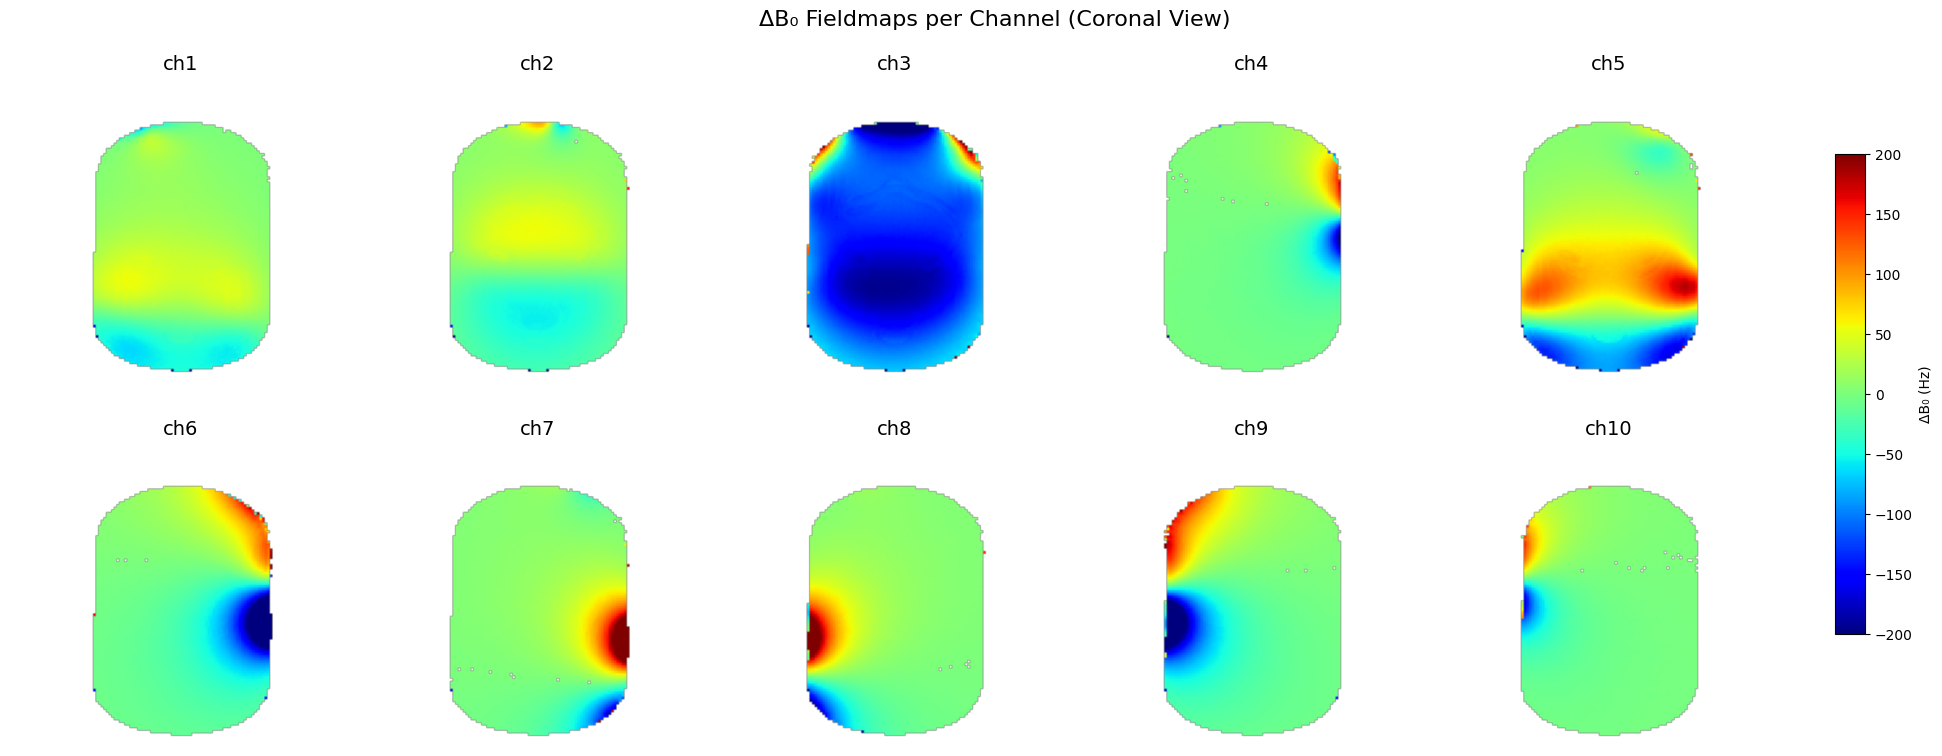

In [277]:
visualize_all_channels(
    root_folder="SF_coil_profile_nii",
    slice_index=103,
    view='coronal',
    vmin=-200,
    vmax=200,
    save_path="SF_fieldmap_channels_axial.png"
)
